In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode

import sys
sys.path.append('../')
from CAS import *


## ABCD-o graphs

* ground-truth saved in 'gt' vertex attribute


In [2]:
# ABCD+o only in Julia for now - update path below as needed

## local:
# abcd_path = '/Users/francois/ABCD/ABCDo/ABCDGraphGenerator.jl/utils/'
# julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia '

## Dev02:
abcd_path = '/work/home/fcthebe/ABCD/ABCDGraphGenerator.jl-master/utils/'
julia = '/work/home/fcthebe/julia-1.7.2/bin/julia '

def _run_julia_abcd(n=1000, xi=0.3, delta=5, zeta=0.5, gamma=2.5, s=25, tau=0.825, beta=1.5, seed=123, nout=0):
    D = int(n**zeta)
    S = int(n**tau) 
    rdm = str(np.random.choice(100000))
    fn_deg = 'deg_'+rdm+'.dat'
    fn_cs = 'cs_'+rdm+'.dat'
    fn_comm = 'comm_'+rdm+'.dat'
    fn_net = 'net_'+rdm+'.dat'
    ## generate graph
    cmd = julia+abcd_path+'deg_sampler.jl '+fn_deg+' '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000 '+str(seed)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'com_sampler.jl '+fn_cs+' '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000 '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'graph_sampler.jl '+fn_net+' '+fn_comm+' '+fn_deg+' '+fn_cs+' xi '+str(xi)+' false false '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    g = ig.Graph.Read_Ncol(fn_net,directed=False)
    c = np.loadtxt(fn_comm,dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(i['name'])-1]-1 for i in g.vs]
    g.vs['gt'] = gt
    cmd = 'rm *_'+rdm+'.dat'
    os.system(cmd+' >/dev/null 2>&1')
    return g

In [3]:
## this assumes community 0 are outliers and 'gt' exists in graph G
## M: membership matrix
## S: score matrix (C or Beta)
def outliers_AUC(G, M, S):
    y = [int(x>0) for x in G.vs['gt']]
    x = np.array(S.max(axis=1).todense()).flatten()
    ctr = Counter(np.array(M.sum(axis=1)).flatten())
    print('With matrix M:\noutliers:',ctr[0])
    print('correct outliers:',sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(G.vs['gt']) == 0)))
    print('\nWith scores:\noutlier AUC:',AUC(y,x)) 
        

In [4]:
## first with "mid-size" graphs
XIs = [.35,.4,.45,.5,.55,.575,.6,.625,.65]
REP = 1
num_nodes = 1000
num_out = 25
delta = 10
min_comm = 50
alpha = 1


### (4) looking at the edges - Beta and C scores

* Blue: both in same community
* Red: in two communities
* Green: one is outlier
* White: both outliers


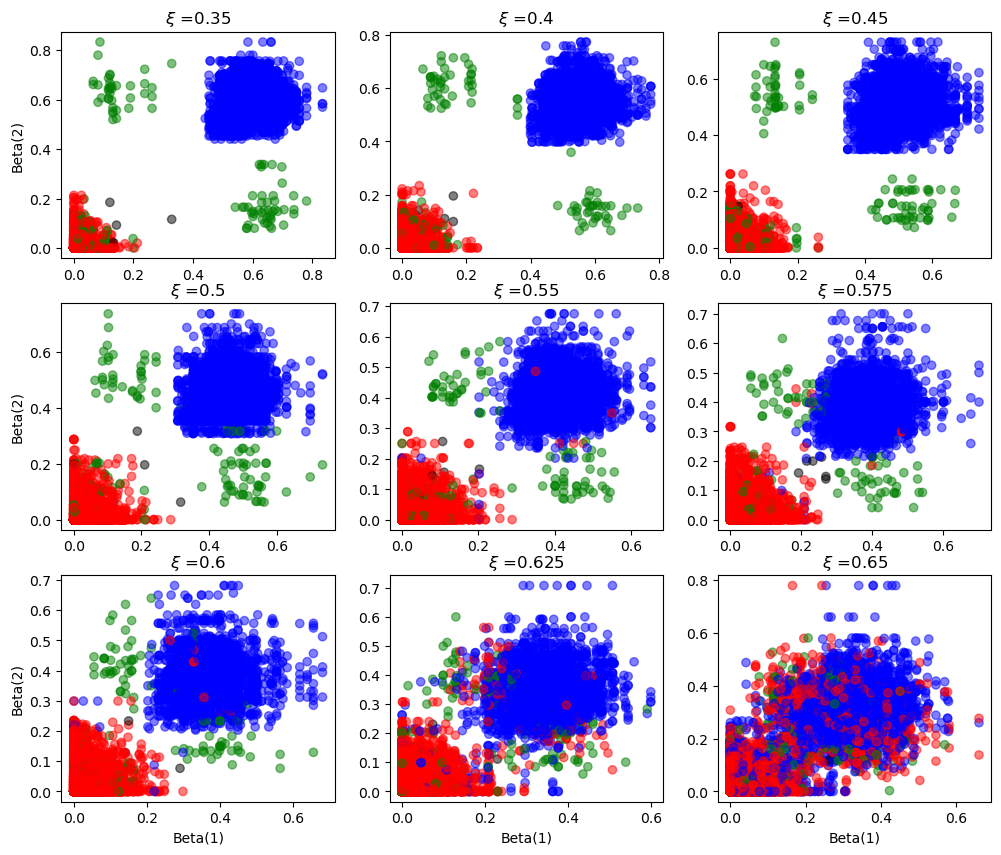

In [8]:
cls = ['red','blue', 'green', 'black']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                        zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)
    g.vs['leiden'] = g.community_ecg(ens_size=32, final='leiden').membership
    A = g.get_adjacency_sparse()
    
    plt.subplot(3,3,i+1)

    L = []
    IEF, Beta, C, P, DegPArt = CAS(A, partition2sparse(g.vs['leiden']))
    Beta = Beta.toarray()
    for e in g.es:
        L.append([Beta[e.source][g.vs[e.target]['leiden']],   ##  score of node u w.r.t. community of node v
              Beta[e.target][g.vs[e.source]['leiden']],       ##  score of node v w.r.t. community of node u
              int( ( g.vs[e.source]['gt'] == g.vs[e.target]['gt'] ) & ( (g.vs[e.source]['gt'] + g.vs[e.target]['gt']) > 0 ) )
                 ] ## flag - both nodes in same GT community
             )
        e['color'] = 0
        if ( g.vs[e.source]['gt'] == g.vs[e.target]['gt'] ) & ( (g.vs[e.source]['gt'] + g.vs[e.target]['gt']) > 0 ):
            e['color'] = 1
        if ( g.vs[e.source]['gt']==0 or g.vs[e.target]['gt']==0 ):
            e['color'] = 2
        if ( g.vs[e.source]['gt']==0 and g.vs[e.target]['gt']==0 ):
            e['color'] = 3                

    D = pd.DataFrame(L, columns=['X','Y','internal']) 

    ## Plot 2-d scatter
    c = [cls[i] for i in g.es['color']]
    plt.scatter(D.X, D.Y, c=c, alpha=.5)
    plt.title(r'$\xi$ ='+str(xi))
    if i%3==0:
        plt.ylabel('Beta(2)')
    if i>5:
        plt.xlabel('Beta(1)')


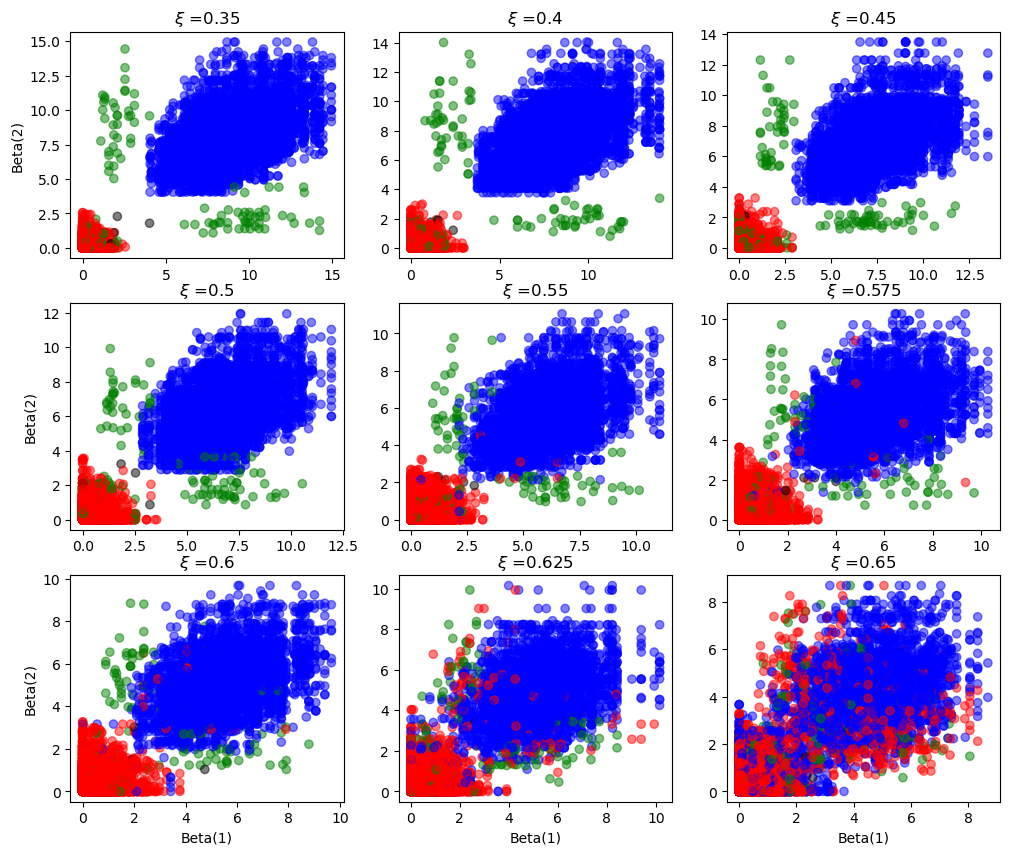

In [11]:
cls = ['red','blue', 'green', 'black']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                        zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)
    g.vs['leiden'] = g.community_ecg(ens_size=32, final='leiden').membership
    A = g.get_adjacency_sparse()
    
    plt.subplot(3,3,i+1)

    L = []
    IEF, Beta, C, P, DegPArt = CAS(A, partition2sparse(g.vs['leiden']))
    Beta = C.toarray()
    for e in g.es:
        L.append([Beta[e.source][g.vs[e.target]['leiden']],   ##  score of node u w.r.t. community of node v
              Beta[e.target][g.vs[e.source]['leiden']],       ##  score of node v w.r.t. community of node u
              int( ( g.vs[e.source]['gt'] == g.vs[e.target]['gt'] ) & ( (g.vs[e.source]['gt'] + g.vs[e.target]['gt']) > 0 ) )
                 ] ## flag - both nodes in same GT community
             )
        e['color'] = 0
        if ( g.vs[e.source]['gt'] == g.vs[e.target]['gt'] ) & ( (g.vs[e.source]['gt'] + g.vs[e.target]['gt']) > 0 ):
            e['color'] = 1
        if ( g.vs[e.source]['gt']==0 or g.vs[e.target]['gt']==0 ):
            e['color'] = 2
        if ( g.vs[e.source]['gt']==0 and g.vs[e.target]['gt']==0 ):
            e['color'] = 3                

    D = pd.DataFrame(L, columns=['X','Y','internal']) 

    ## Plot 2-d scatter
    c = [cls[i] for i in g.es['color']]
    plt.scatter(D.X, D.Y, c=c, alpha=.5)
    plt.title(r'$\xi$ ='+str(xi))
    if i%3==0:
        plt.ylabel('Beta(2)')
    if i>5:
        plt.xlabel('Beta(1)')
#plt.savefig('edges_beta.png');


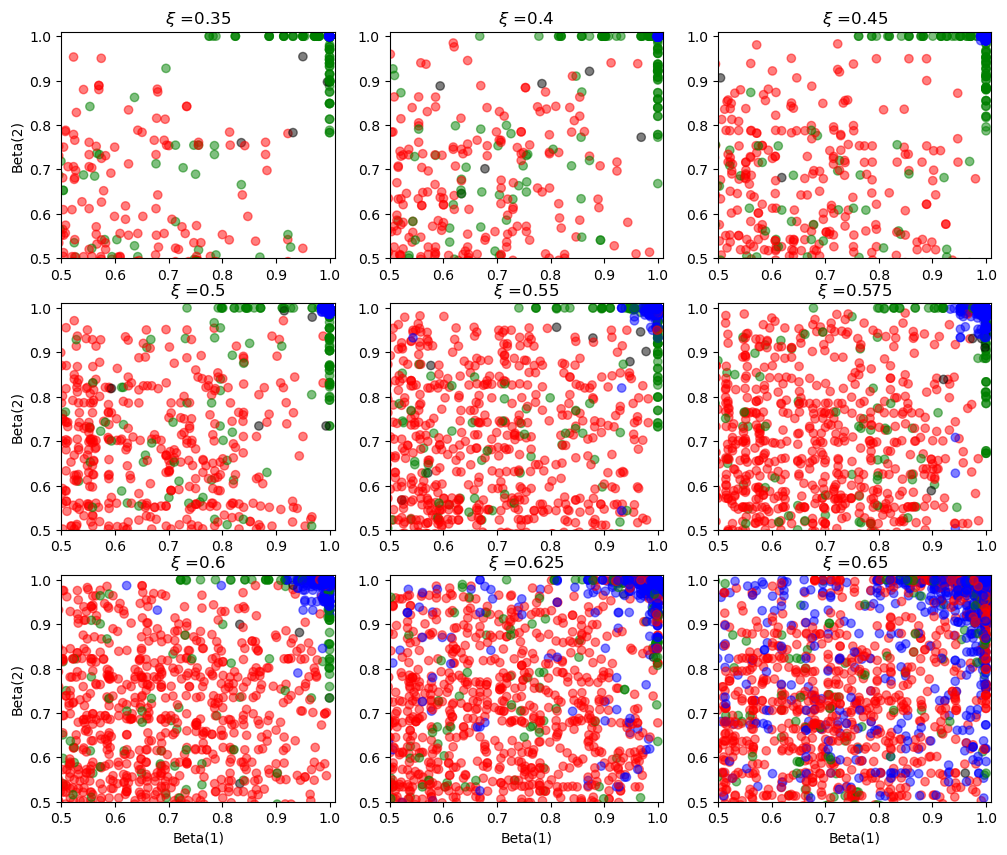

In [24]:
cls = ['red','blue', 'green', 'black']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                        zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)
    g.vs['leiden'] = g.community_ecg(ens_size=32, final='leiden').membership
    A = g.get_adjacency_sparse()
    
    plt.subplot(3,3,i+1)

    L = []
    IEF, Beta, C, P, DegPArt = CAS(A, partition2sparse(g.vs['leiden']))
    Beta = P.toarray()
    for e in g.es:
        L.append([Beta[e.source][g.vs[e.target]['leiden']],   ##  score of node u w.r.t. community of node v
              Beta[e.target][g.vs[e.source]['leiden']],       ##  score of node v w.r.t. community of node u
              int( ( g.vs[e.source]['gt'] == g.vs[e.target]['gt'] ) & ( (g.vs[e.source]['gt'] + g.vs[e.target]['gt']) > 0 ) )
                 ] ## flag - both nodes in same GT community
             )
        e['color'] = 0
        if ( g.vs[e.source]['gt'] == g.vs[e.target]['gt'] ) & ( (g.vs[e.source]['gt'] + g.vs[e.target]['gt']) > 0 ):
            e['color'] = 1
        if ( g.vs[e.source]['gt']==0 or g.vs[e.target]['gt']==0 ):
            e['color'] = 2
        if ( g.vs[e.source]['gt']==0 and g.vs[e.target]['gt']==0 ):
            e['color'] = 3                

    D = pd.DataFrame(L, columns=['X','Y','internal']) 

    ## Plot 2-d scatter
    c = [cls[i] for i in g.es['color']]
    plt.scatter((D.X), (D.Y), c=c, alpha=.5)
    plt.xlim((.5,1.01))
    plt.ylim((.5,1.01))
    plt.title(r'$\xi$ ='+str(xi))
    if i%3==0:
        plt.ylabel('Beta(2)')
    if i>5:
        plt.xlabel('Beta(1)')
#plt.savefig('edges_beta.png');


In [26]:
rising_tide(A, Beta)

NameError: name 'M' is not defined

# Testing with larger ABCD-o graphs


## Experiment with n = 1M

In [ ]:
xi = 0.5
num_out = 1000
delta = 10
num_nodes = 1000000
min_comm = int(num_nodes/1000)
seed = 6666 ## 3333
np.random.seed(seed)
random.seed(seed)

## ABCD+o graph
start = time.time()
g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, 
                    s=min_comm, tau = 0.767, nout=num_out, seed=123)
t_abcd = time.time() - start

## Leiden
start = time.time()
algo = g.community_leiden(objective_function='modularity')
t_leiden = time.time() - start
g.vs['algo'] = algo.membership

## beta+C
start = time.time()
Beta, C, M = beta_and_C_overlap(g, partition2sparse(g.vs['algo']), repeats=0, verbose=False, min_deg_in = 2)
t_betaC = time.time() - start

## timings
v = [num_nodes, g.ecount(),AMI(g.vs['algo'], g.vs['gt']),t_abcd,t_leiden,t_betaC]
print(v)
    

In [ ]:
## AUC - identify outliers

## C-score
g.vs['c'] = top2(C)[:,0]
y = [int(x>0) for x in g.vs['gt']]
fpr, tpr, thresholds = roc_curve(y, g.vs['c'], pos_label=1)
auc = AUC(y, g.vs['c'])
plt.plot(fpr, tpr, label='C: '+str(round(auc,3)))

## Beta-score
g.vs['beta'] = top2(Beta)[:,0]
y = [int(x>0) for x in g.vs['gt']]
fpr, tpr, thresholds = roc_curve(y, g.vs['beta'], pos_label=1)
auc = AUC(y, g.vs['beta'])
plt.plot(fpr, tpr, label='Beta: '+str(round(auc,3)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title(r'$\xi$ ='+str(xi));


In [ ]:
## Beta-score as a threshold for outliers
L = []
for bs in np.arange(.1,.61,.02):
    L.append([xi, bs, 
              sum(np.array(g.vs['beta']) < bs), 
              sum( (np.array(g.vs['beta']) < bs) & (np.array(g.vs['gt']) == 0) )])       
D = pd.DataFrame(L, columns=['xi','b_star','outliers','TP'])
D['FP'] = D['outliers'] - D['TP']

plt.plot(D.b_star,D.TP,label='True Positives')
plt.plot(D.b_star,D.FP,label='False Positives')
plt.xlim((.1,.38))
plt.ylim((-10,2000))
plt.hlines(y=num_out, xmin=.1, xmax=.6,linestyles='dotted', color='grey');
plt.legend()
plt.xlabel('Beta-star')
plt.ylabel('Count');
plt.title(r'Outliers with $\xi$ ='+str(xi));


In [ ]:
## C-score as a threshold for outliers
L = []
for cs in [1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]:
    L.append([xi, cs, 
              sum(np.array(g.vs['c']) < cs), 
              sum( (np.array(g.vs['c']) < cs) & (np.array(g.vs['gt']) == 0) )])       
D = pd.DataFrame(L, columns=['xi','b_star','outliers','TP'])
D['FP'] = D['outliers'] - D['TP']

plt.semilogy(D.b_star,D.TP,label='True Positives')
plt.semilogy(D.b_star,D.FP,label='False Positives')
#plt.xlim((.1,.4))
#plt.ylim((-10,2000))
plt.hlines(y=num_out, xmin=.1, xmax=10,linestyles='dotted', color='grey');
plt.legend()
plt.xlabel('C-star')
plt.ylabel('Count');
plt.title(r'Outliers with $\xi$ ='+str(xi));


In [ ]:
## Respective boxplots for the C-score
df = pd.DataFrame()
df['c'] = g.vs['c']
df['beta'] = g.vs['beta']
df['outlier'] = np.array(g.vs['gt'])==0
df.boxplot(column='c', by='outlier', showfliers=False);


In [ ]:
## Respective boxplots for the Beta score
df.boxplot(column='beta', by='outlier', showfliers=False);


### Outliers vs low-C score non-outliers

In [ ]:
## V-set: non-outliers with C-score < 5
b = (np.array(g.vs['c'])<5) & (np.array(g.vs['gt'])>0)
V = np.where(b)[0]
g.vs['deg'] = g.degree()
Counter([v['deg'] for v in g.vs[V]])

## O-set: outlier nodes
O = np.array([i for i in range(g.vcount()) if g.vs[i]['gt']==0])

print(len(V), len(O))

In [ ]:
## C-score distribution, O and V-set
plt.boxplot([ [v['c'] for v in g.vs[O]] , [v['c'] for v in g.vs[V]] ], labels=['Outliers','Low-C non-Outliers'], sym='.' )
plt.ylabel('C-score');


In [ ]:
## Beta-score distribution, O and V-set
plt.boxplot([ [v['beta'] for v in g.vs[O]] , [v['beta'] for v in g.vs[V]] ], labels=['Outliers','Low-C non-Outliers'], sym='.')
plt.ylabel('Beta-score');


In [ ]:
## largest proportion of edges toward a community - O and V-set nodes
for i in V:
    g.vs[i]['mc'] = Counter([v['algo'] for v in g.vs[i].neighbors()]).most_common(1)[0][1]
for i in O:
    g.vs[i]['mc'] = Counter([v['algo'] for v in g.vs[i].neighbors()]).most_common(1)[0][1]
plt.boxplot([ [v['mc']/v['deg'] for v in g.vs[O]] , [v['mc']/v['deg'] for v in g.vs[V]] ], labels=['Outliers','Low-C non-Outliers'], sym='.')
plt.ylabel('Largest proportion of community edges')
plt.grid(linestyle=':');


## Timings with larger graphs


In [ ]:
xi = 0.5
num_out = 1000
delta = 10
L = []

for num_nodes in np.arange(10000000,15000001,2500000):
    min_comm = int(num_nodes/1000)

    start = time.time()
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, 
                        s=min_comm, tau = 0.767, nout=num_out, seed=123)
    t_abcd = time.time() - start

    start = time.time()
    
    seed = 777
    np.random.seed(seed)
    random.seed(seed)
    
    algo = g.community_leiden(objective_function='modularity')
    t_leiden = time.time() - start
    g.vs['algo'] = algo.membership

    start = time.time()
    Beta, C, M = beta_and_C_overlap(g, partition2sparse(g.vs['algo']), repeats=0, verbose=False, min_deg_in = 2)
    t_betaC = time.time() - start
    v = [num_nodes, g.ecount(),AMI(g.vs['algo'], g.vs['gt']),t_abcd,t_leiden,t_betaC]
    print(v)
    L.append(v)
    

# Old code below